<a href="https://kritikseth.github.io/ipynbtagredirect" target="_parent"><img src="https://raw.githack.com/kritikseth/kritikseth/master/assets/icons/kritik_ipynbtagredirect.svg" alt="Kritik Seth"/></a>

<h1 style="background-color:#2d6187;color:white;font-family:Arial;font-size:350%;text-align:center">Flowers Classification</h1>

In [1]:
!wget http://upscfever.com/datasets/flowers-new.zip -P drive/app -q
import os
os.chdir('drive/app')
!unzip -q flowers-new.zip

In [2]:
import pandas as pd
import numpy as np

import os
import cv2
from PIL import Image

from matplotlib import pyplot as plt
%matplotlib inline
from ipywidgets import interact

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

In [3]:
def plotImages(dir, label, num=10):
    import random
    nos = random.sample(range(len(dir)), num)
    i=0
    fig = plt.figure(figsize=(10, 6))
    for no in nos:
        if i > num-1:
            break
        img = dir[no]
        ax = fig.add_subplot(4, 5, i+1, xticks=[], yticks=[])
        img = cv2.imread(img)
        ax.set_xlabel(f'Flower: {label[no].title()}')
        ax.imshow(img)
        i+=1

def plot_train_val_metrics(history):
    fig = make_subplots(rows=1, cols=2,
                        subplot_titles=('Accuracy', 'Loss'))

    fig.add_trace(go.Scatter(y=history.history['acc'],
                            mode='lines',
                            name='Train',
                            marker_color='#ff414d',
                            opacity=0.75),
                row=1, col=1)

    fig.add_trace(go.Scatter(y=history.history['val_acc'],
                            mode='lines',
                            name='Validation',
                            marker_color='#1f4068',
                            opacity=0.75),
                row=1, col=1)

    fig.add_trace(go.Scatter(y=history.history['loss'],
                            mode='lines',
                            name='Train',
                            marker_color='#ff414d',
                            opacity=0.75),
                row=1, col=2)
    
    fig.add_trace(go.Scatter(y=history.history['val_loss'],
                            mode='lines',
                            name='Validation',
                            marker_color='#1f4068',
                            opacity=0.75),
                row=1, col=2)

    fig.show()

In [4]:
DIR = '/content/drive/app/flowers'
img_rows, img_cols = (180, 180)
input_shape = (img_rows, img_cols, 3)

In [5]:
image_list = []
for dirname, _, filenames in os.walk(DIR):
    for filename in filenames:
        image_list.append(os.path.join(dirname, filename))

In [6]:
image_path = pd.DataFrame()
for img in image_list:
    image_path = image_path.append({'Path': img,
                                    'Label': img.split('/')[5]},
                                   ignore_index=True)

In [7]:
for image in image_list:
    img = cv2.imread(image)
    img = cv2.resize(img, (img_rows, img_cols))
    cv2.imwrite(image, img)

In [8]:
Y = image_path['Label']

In [9]:
labels = Y.unique().tolist()
ids = list(range(5))
ids = [str(i) for i in ids]
labels_ids = dict(zip(labels, ids))

## Generating New Images

In [10]:
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score

In [11]:
datagen = ImageDataGenerator(rotation_range=10,
                             zoom_range=0.10,
                             width_shift_range=0.05,
                             height_shift_range=0.05,
                             shear_range=0.05,
                             fill_mode='nearest',
                             horizontal_flip=True,
                             brightness_range=[0.1,0.5])

In [12]:
!mkdir flower_images
dir = ''

for flower in labels:
    for x, val in zip(datagen.flow_from_dataframe(dataframe=image_path[image_path['Label']==flower],
                                                  directory=dir,
                                                  x_col='Path',
                                                  y_col='Label',
                                                  target_size=(img_rows, img_cols),
                                                  color_mode='rgb',
                                                  save_prefix=flower,
                                                  save_to_dir='/content/drive/app/flower_images',
                                                  save_format='jpg',
                                                  seed=42), range(50)):
        pass

Found 26 validated image filenames belonging to 1 classes.
Found 26 validated image filenames belonging to 1 classes.
Found 26 validated image filenames belonging to 1 classes.
Found 13 validated image filenames belonging to 1 classes.
Found 26 validated image filenames belonging to 1 classes.


In [13]:
NEW_DIR = '/content/drive/app/flower_images'
aug_image_list = os.listdir(NEW_DIR)

In [14]:
for img in aug_image_list:
    image_path = image_path.append({'Path': NEW_DIR+'/'+img,
                                    'Label': img.split('_')[0]},
                                    ignore_index=True)

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
Y = image_path['Label']
image_path.drop(['Label'], axis=1, inplace=True)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(image_path, Y, test_size=0.2, random_state=42)

y_train = y_train.map(labels_ids)
y_test = y_test.map(labels_ids)

X_train['Label'] = y_train
X_test['Label'] = y_test

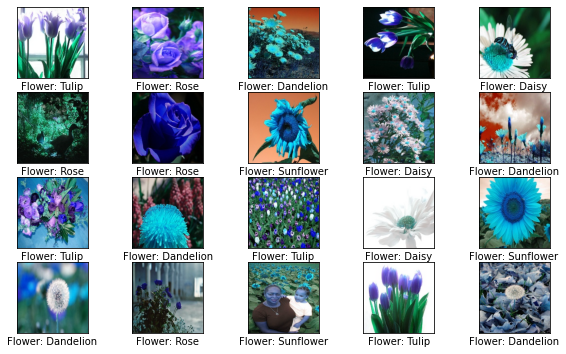

In [18]:
plotImages(image_list, Y.tolist(), 20)

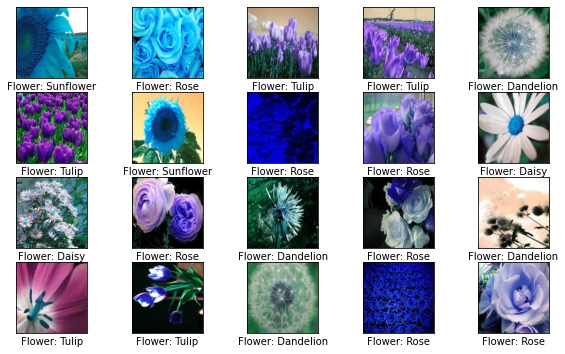

In [19]:
plotImages(image_list, Y.tolist(), 20)

In [20]:
val_split= 0.2

train_datagen = ImageDataGenerator(rescale=1/255.0,
                                   validation_split=val_split)

test_datagen = ImageDataGenerator(rescale=1/255.0)

In [21]:
dir = ''

train_aug = train_datagen.flow_from_dataframe(dataframe=X_train,
                                              directory=dir,
                                              x_col='Path',
                                              y_col='Label',
                                              target_size=(img_rows, img_cols),
                                              class_mode='categorical',
                                              subset='training',
                                              shuffle=False,
                                              color_mode='rgb',
                                              seed=42)

valid_aug = train_datagen.flow_from_dataframe(dataframe=X_train,
                                              directory=dir,
                                              x_col='Path',
                                              y_col='Label',
                                              target_size=(img_rows, img_cols),
                                              class_mode='categorical',
                                              subset='validation',
                                              shuffle=False,
                                              color_mode='rgb',
                                              seed=42)

test_aug = test_datagen.flow_from_dataframe(dataframe=X_test,
                                            directory=dir,
                                            x_col='Path',
                                            y_col='Label',
                                            target_size=(img_rows, img_cols),
                                            class_mode='categorical',
                                            shuffle=False,
                                            color_mode='rgb')

Found 3894 validated image filenames belonging to 5 classes.
Found 973 validated image filenames belonging to 5 classes.
Found 1217 validated image filenames belonging to 5 classes.


In [22]:
import keras
import tensorflow as tf
from tqdm.keras import TqdmCallback

from sklearn.metrics import precision_score, recall_score

In [23]:
train_labels = keras.utils.to_categorical(X_train['Label'])

## Feed Forward Networks (ANN)

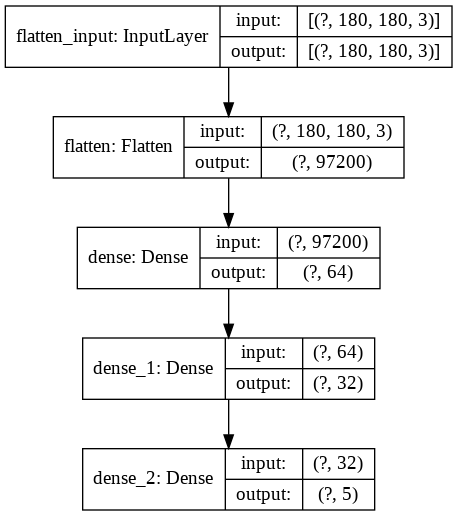

In [24]:
ann = keras.models.Sequential()

ann.add(keras.layers.Flatten(input_shape=input_shape))
ann.add(keras.layers.Dense(units=64, activation='relu'))
ann.add(keras.layers.Dense(units=32, activation='relu'))
ann.add(keras.layers.Dense(units=5, activation='softmax'))

keras.utils.plot_model(ann, show_shapes=True, show_layer_names=True)

In [25]:
ch = tf.keras.callbacks.ModelCheckpoint(
    filepath='ann.hdf5',
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True
)

es = tf.keras.callbacks.EarlyStopping(
    monitor='val_acc',
    min_delta=0.003,
    patience=15,
    mode='max',
    restore_best_weights=True,
)

lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_acc',
    factor=0.005,
    patience=3,
    mode='max',
)

In [26]:
ann.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [27]:
history = ann.fit(train_aug, validation_data=valid_aug, epochs=50, verbose=0,
                  callbacks=[ch, es, lr, TqdmCallback(verbose=1)])

In [28]:
ann.evaluate(test_aug)

39/39 [==============================] - 1s 36ms/step - loss: 0.2296 - acc: 0.9129


[0.22957421839237213, 0.9129005670547485]

### Accuracy Screenshot- 0.9129


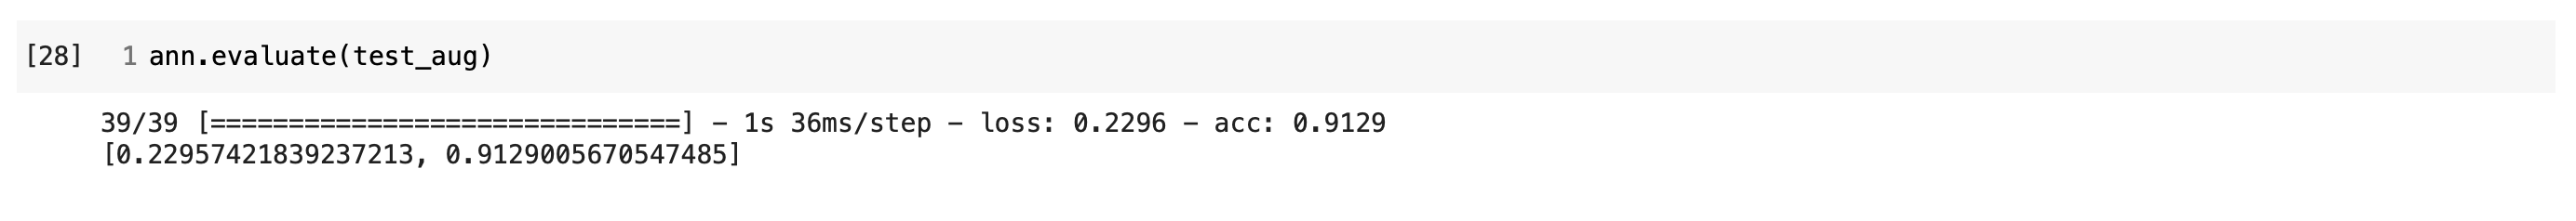

### Training vs Validation 

**Accuracy vs Loss** Plots

In [29]:
# plot_train_val_metrics(history)

## Convolutional Neural Network

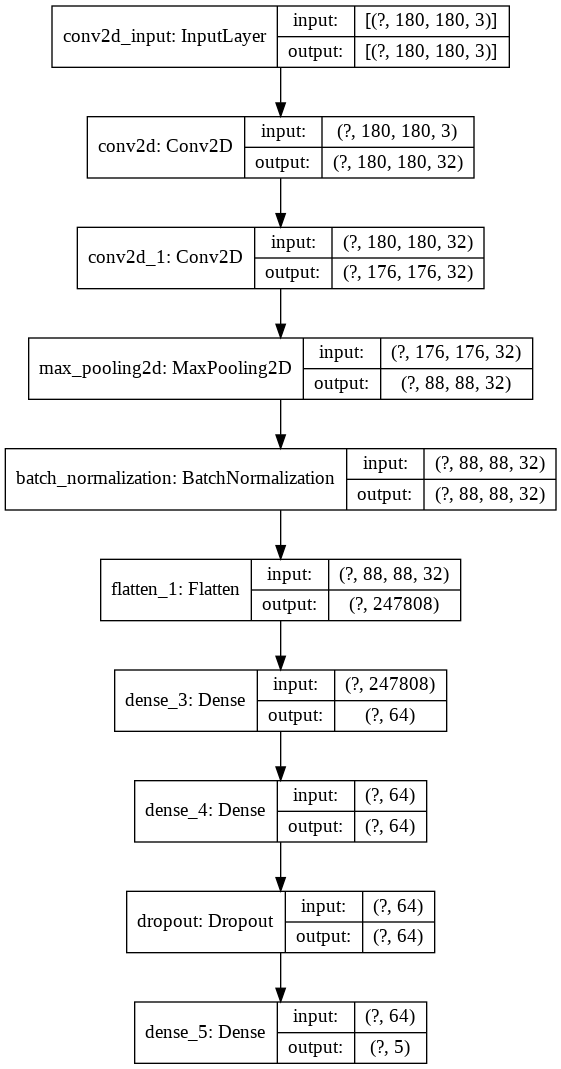

In [30]:
cnn = keras.models.Sequential()

cnn.add(keras.layers.Conv2D(filters=32, kernel_size=(5, 5), activation='relu', padding='same', input_shape=input_shape))
cnn.add(keras.layers.Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
cnn.add(keras.layers.MaxPool2D(pool_size=(2, 2)))
cnn.add(keras.layers.BatchNormalization())

cnn.add(keras.layers.Flatten())
cnn.add(keras.layers.Dense(units=64, activation='relu'))
cnn.add(keras.layers.Dense(units=64, activation='relu'))
cnn.add(keras.layers.Dropout(0.3))

cnn.add(keras.layers.Dense(units=5, activation='softmax'))

keras.utils.plot_model(cnn, show_shapes=True, show_layer_names=True)

In [31]:
cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [32]:
ch = tf.keras.callbacks.ModelCheckpoint(
    filepath='ann.hdf5',
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True
)

es = tf.keras.callbacks.EarlyStopping(
    monitor='val_acc',
    min_delta=0.003,
    patience=15,
    mode='max',
    restore_best_weights=True,
)

lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_acc',
    factor=0.005,
    patience=3,
    mode='max',
)

In [33]:
history = cnn.fit(train_aug, validation_data=valid_aug, epochs=50, verbose=0,
                    callbacks=[ch, es, lr, TqdmCallback(verbose=1)])

In [34]:
cnn.evaluate(test_aug)

39/39 [==============================] - 2s 41ms/step - loss: 0.0228 - acc: 0.9942


[0.022782769054174423, 0.9942481517791748]

### Accuracy Screenshot- 0.9942

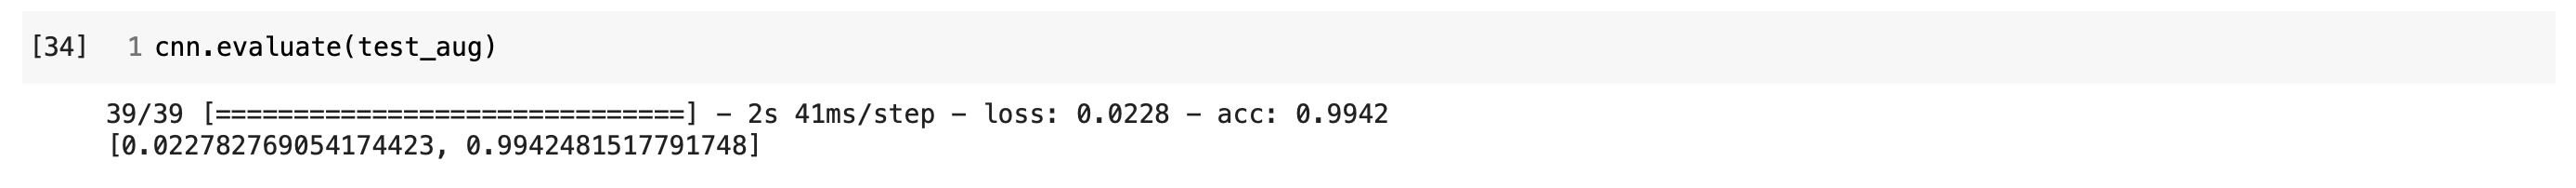

### Training vs Validation 

**Accuracy vs Loss** Plots

In [35]:
plot_train_val_metrics(history)